In [1]:
# Setup CUDA library paths for JAX GPU support
import os
import sys
import ctypes
import glob

# Find the nvidia CUDA packages - search all site-packages directories
nvidia_base = None
for path in sys.path:
    potential_nvidia = os.path.join(path, 'nvidia')
    if os.path.exists(potential_nvidia) and os.path.isdir(potential_nvidia):
        nvidia_base = potential_nvidia
        print(f"Found nvidia packages at: {nvidia_base}")
        break

if nvidia_base:
    lib_dirs = glob.glob(f"{nvidia_base}/*/lib")
    
    if lib_dirs:
        current_ld_path = os.environ.get('LD_LIBRARY_PATH', '')
        new_ld_path = ':'.join(lib_dirs)
        if current_ld_path:
            new_ld_path = f"{new_ld_path}:{current_ld_path}"
        os.environ['LD_LIBRARY_PATH'] = new_ld_path
        
        preloaded = []
        for lib_dir in lib_dirs:
            for lib_name in ['libcudart.so.12', 'libcublas.so.12', 'libcublasLt.so.12']:
                lib_path = os.path.join(lib_dir, lib_name)
                if os.path.exists(lib_path):
                    try:
                        ctypes.CDLL(lib_path, mode=ctypes.RTLD_GLOBAL)
                        preloaded.append(lib_name)
                    except Exception as e:
                        print(f"Warning loading {lib_name}: {e}")
        
        print(f"✓ Set LD_LIBRARY_PATH with {len(lib_dirs)} CUDA directories")
        print(f"✓ Preloaded {len(set(preloaded))} CUDA libraries")
    else:
        print(f"⚠ Found nvidia directory but no lib subdirectories")
else:
    print("⚠ Could not find nvidia CUDA packages in sys.path")

Found nvidia packages at: /mnt/c/Users/makis/Documents/GitHub/braxphysics/venv_gpu/lib/python3.12/site-packages/nvidia
✓ Set LD_LIBRARY_PATH with 12 CUDA directories
✓ Preloaded 3 CUDA libraries


In [2]:
# Check GPU availability
import jax
print("JAX version:", jax.__version__)
print("Available devices:", jax.devices())
print("Default backend:", jax.default_backend())

JAX version: 0.8.2
Available devices: [CudaDevice(id=0)]
Default backend: gpu


In [3]:
# Imports
from jax import numpy as jp
from brax import envs
from brax.io import html
from brax.training.agents.ppo import train as ppo
from brax.training.agents.ppo import networks as ppo_networks

Failed to import warp: No module named 'warp'
Failed to import mujoco_warp: No module named 'warp'


In [4]:
# Natural Walking Humanoid Environment

from brax.envs.base import PipelineEnv, State

class NaturalWalkingHumanoid(PipelineEnv):
    """Humanoid environment with rewards shaped for natural human-like walking.
    
    Key improvements for natural gait:
    1. Target velocity reward (penalize being too fast OR too slow)
    2. ARM SWING reward (arms should swing opposite to legs)
    3. FOOT SPACING reward (feet shoulder-width apart, not on a line)
    4. Upright posture reward (keep torso vertical)
    5. Smoothness reward (penalize jerky motions)
    """
    
    def __init__(
        self,
        target_velocity: float = 1.4,      # Normal human walking ~1.4 m/s
        velocity_reward_weight: float = 2.0,
        forward_reward_weight: float = 0.5,
        ctrl_cost_weight: float = 0.1,
        healthy_reward: float = 3.0,
        posture_reward_weight: float = 1.0,
        smoothness_reward_weight: float = 0.3,
        arm_swing_reward_weight: float = 1.5,
        foot_spacing_reward_weight: float = 1.0,
        terminate_when_unhealthy: bool = True,
        healthy_z_range: tuple = (0.8, 2.0),
        reset_noise_scale: float = 1e-2,
        backend: str = 'generalized',
        **kwargs,
    ):
        from brax.io import mjcf
        from etils import epath
        
        path = epath.resource_path('brax') / 'envs/assets/humanoid.xml'
        sys = mjcf.load(path)
        
        n_frames = 5
        if backend in ['spring', 'positional']:
            sys = sys.tree_replace({'opt.timestep': 0.0015})
            n_frames = 10
            
        kwargs['n_frames'] = kwargs.get('n_frames', n_frames)
        super().__init__(sys=sys, backend=backend, **kwargs)
        
        self._target_velocity = target_velocity
        self._velocity_reward_weight = velocity_reward_weight
        self._forward_reward_weight = forward_reward_weight
        self._ctrl_cost_weight = ctrl_cost_weight
        self._healthy_reward = healthy_reward
        self._posture_reward_weight = posture_reward_weight
        self._smoothness_reward_weight = smoothness_reward_weight
        self._arm_swing_reward_weight = arm_swing_reward_weight
        self._foot_spacing_reward_weight = foot_spacing_reward_weight
        self._terminate_when_unhealthy = terminate_when_unhealthy
        self._healthy_z_range = healthy_z_range
        self._reset_noise_scale = reset_noise_scale
        
        # Body part indices
        self._torso_idx = 0
        self._right_foot_idx = 5
        self._left_foot_idx = 8
        self._right_upper_arm_idx = 9
        self._left_upper_arm_idx = 11
        self._right_thigh_idx = 3
        self._left_thigh_idx = 6
        
    def reset(self, rng: jax.Array) -> State:
        rng, rng1, rng2 = jax.random.split(rng, 3)
        
        low, hi = -self._reset_noise_scale, self._reset_noise_scale
        qpos = self.sys.init_q + jax.random.uniform(
            rng1, (self.sys.q_size(),), minval=low, maxval=hi
        )
        qvel = jax.random.uniform(
            rng2, (self.sys.qd_size(),), minval=low, maxval=hi
        )
        
        pipeline_state = self.pipeline_init(qpos, qvel)
        obs = self._get_obs(pipeline_state, jp.zeros(self.sys.act_size()))
        
        reward, done, zero = jp.zeros(3)
        metrics = {
            'forward_reward': zero,
            'velocity_reward': zero,
            'posture_reward': zero,
            'smoothness_reward': zero,
            'arm_swing_reward': zero,
            'foot_spacing_reward': zero,
            'reward_ctrl': zero,
            'reward_alive': zero,
            'x_position': zero,
            'x_velocity': zero,
            'distance_from_origin': zero,
        }
        return State(pipeline_state, obs, reward, done, metrics)
    
    def step(self, state: State, action: jax.Array) -> State:
        action_min = self.sys.actuator.ctrl_range[:, 0]
        action_max = self.sys.actuator.ctrl_range[:, 1]
        action = (action + 1) * (action_max - action_min) * 0.5 + action_min
        
        pipeline_state0 = state.pipeline_state
        pipeline_state = self.pipeline_step(pipeline_state0, action)
        
        com_before = self._com(pipeline_state0)
        com_after = self._com(pipeline_state)
        velocity = (com_after - com_before) / self.dt
        x_velocity = velocity[0]
        
        body_pos = pipeline_state.x.pos
        body_vel = pipeline_state.xd.vel
        
        # 1. Forward reward
        forward_reward = self._forward_reward_weight * x_velocity
        
        # 2. Velocity targeting reward
        velocity_error = jp.abs(x_velocity - self._target_velocity)
        velocity_reward = self._velocity_reward_weight * jp.exp(-velocity_error**2 / 0.5)
        
        # 3. Posture reward
        torso_z = body_pos[self._torso_idx, 2]
        torso_upright = jp.clip(torso_z - 1.0, 0, 0.5) / 0.5
        posture_reward = self._posture_reward_weight * torso_upright
        
        # 4. Smoothness reward
        smoothness_reward = self._smoothness_reward_weight
        
        # 5. ARM SWING REWARD
        right_arm_vel_x = body_vel[self._right_upper_arm_idx, 0]
        left_arm_vel_x = body_vel[self._left_upper_arm_idx, 0]
        right_leg_vel_x = body_vel[self._right_thigh_idx, 0]
        left_leg_vel_x = body_vel[self._left_thigh_idx, 0]
        
        arm_leg_opposition = (
            -right_arm_vel_x * right_leg_vel_x +
            -left_arm_vel_x * left_leg_vel_x
        )
        arm_swing_reward = self._arm_swing_reward_weight * jp.tanh(arm_leg_opposition * 0.5)
        
        # 6. FOOT SPACING REWARD
        right_foot_y = body_pos[self._right_foot_idx, 1]
        left_foot_y = body_pos[self._left_foot_idx, 1]
        foot_spacing = jp.abs(right_foot_y - left_foot_y)
        
        target_spacing = 0.2
        spacing_error = jp.abs(foot_spacing - target_spacing)
        foot_spacing_reward = self._foot_spacing_reward_weight * jp.exp(-spacing_error**2 / 0.02)
        
        # 7. Control cost
        ctrl_cost = self._ctrl_cost_weight * jp.sum(jp.square(action))
        
        # 8. Healthy reward
        min_z, max_z = self._healthy_z_range
        is_healthy = jp.where(body_pos[self._torso_idx, 2] < min_z, 0.0, 1.0)
        is_healthy = jp.where(body_pos[self._torso_idx, 2] > max_z, 0.0, is_healthy)
        
        healthy_reward = self._healthy_reward if self._terminate_when_unhealthy else self._healthy_reward * is_healthy
        
        reward = (
            forward_reward + velocity_reward + posture_reward + smoothness_reward +
            arm_swing_reward + foot_spacing_reward + healthy_reward - ctrl_cost
        )
        
        done = 1.0 - is_healthy if self._terminate_when_unhealthy else 0.0
        obs = self._get_obs(pipeline_state, action)
        
        state.metrics.update(
            forward_reward=forward_reward,
            velocity_reward=velocity_reward,
            posture_reward=posture_reward,
            smoothness_reward=smoothness_reward,
            arm_swing_reward=arm_swing_reward,
            foot_spacing_reward=foot_spacing_reward,
            reward_ctrl=-ctrl_cost,
            reward_alive=healthy_reward,
            x_position=com_after[0],
            x_velocity=x_velocity,
            distance_from_origin=jp.linalg.norm(com_after),
        )
        
        return state.replace(
            pipeline_state=pipeline_state, obs=obs, reward=reward, done=done
        )
    
    def _com(self, pipeline_state) -> jax.Array:
        inertia = self.sys.link.inertia
        mass_sum = jp.sum(inertia.mass)
        x_i = pipeline_state.x.vmap().do(inertia.transform)
        com = jp.sum(jax.vmap(jp.multiply)(inertia.mass, x_i.pos), axis=0) / mass_sum
        return com
    
    def _get_obs(self, pipeline_state, action) -> jax.Array:
        position = pipeline_state.q[2:]
        velocity = pipeline_state.qd
        
        com, inertia, mass_sum, x_i = self._com_full(pipeline_state)
        cinr = x_i.replace(pos=x_i.pos - com).vmap().do(inertia)
        com_inertia = jp.hstack(
            [cinr.i.reshape((cinr.i.shape[0], -1)), inertia.mass[:, None]]
        )
        
        from brax.base import Transform
        xd_i = (
            Transform.create(pos=x_i.pos - pipeline_state.x.pos)
            .vmap()
            .do(pipeline_state.xd)
        )
        com_vel = inertia.mass[:, None] * xd_i.vel / mass_sum
        com_ang = xd_i.ang
        com_velocity = jp.hstack([com_vel, com_ang])
        
        from brax import actuator
        qfrc_actuator = actuator.to_tau(
            self.sys, action, pipeline_state.q, pipeline_state.qd
        )
        
        return jp.concatenate([
            position, velocity, com_inertia.ravel(), com_velocity.ravel(),
            qfrc_actuator
        ])
    
    def _com_full(self, pipeline_state):
        inertia = self.sys.link.inertia
        mass_sum = jp.sum(inertia.mass)
        x_i = pipeline_state.x.vmap().do(inertia.transform)
        com = jp.sum(jax.vmap(jp.multiply)(inertia.mass, x_i.pos), axis=0) / mass_sum
        return com, inertia, mass_sum, x_i


# Register and create the environment
envs._envs['natural_humanoid'] = NaturalWalkingHumanoid

env = NaturalWalkingHumanoid(
    target_velocity=1.4,
    velocity_reward_weight=2.0,
    forward_reward_weight=0.5,
    ctrl_cost_weight=0.1,
    healthy_reward=3.0,
    posture_reward_weight=1.0,
    smoothness_reward_weight=0.3,
    arm_swing_reward_weight=1.5,
    foot_spacing_reward_weight=1.0,
    backend='generalized'
)

print("✅ Created Natural Walking Humanoid Environment")
print(f"   Target velocity: 1.4 m/s")
print(f"   Observation size: {env.observation_size}")
print(f"   Action size: {env.action_size}")

/mnt/c/Users/makis/Documents/GitHub/braxphysics/venv_gpu/lib/python3.12/site-packages/brax/io/mjcf.py:480: UserWarning: Brax System, piplines and environments are not actively being maintained. Please see MJX for a well maintained JAX-based physics engine: https://github.com/google-deepmind/mujoco/tree/main/mjx. For a host of environments that use MJX, see: https://github.com/google-deepmind/mujoco_playground.
  warnings.warn(


✅ Created Natural Walking Humanoid Environment
   Target velocity: 1.4 m/s
   Observation size: 244
   Action size: 17


In [5]:
# Train for Natural Walking

print("="*70)
print("🚶 Training for NATURAL WALKING")
print("="*70)

def make_networks_factory(obs_shape, action_size, preprocess_observations_fn=lambda x: x):
    return ppo_networks.make_ppo_networks(
        obs_shape, action_size,
        preprocess_observations_fn=preprocess_observations_fn,
        policy_hidden_layer_sizes=(128, 128, 128, 128),
        value_hidden_layer_sizes=(128, 128, 128, 128),
    )

print("\nTraining started...")
train_fn = lambda: ppo.train(
    environment=env,
    num_timesteps=50_000_000,
    num_evals=20,
    reward_scaling=0.1,
    episode_length=1500,
    normalize_observations=True,
    action_repeat=1,
    unroll_length=20,
    num_minibatches=32,
    num_updates_per_batch=4,
    discounting=0.99,
    learning_rate=3e-4,
    entropy_cost=5e-3,
    num_envs=512,
    batch_size=512,
    network_factory=make_networks_factory,
)

inference_fn, params, metrics = train_fn()
print("\n" + "="*70)
print("✅ Training Complete!")
print("="*70)

🚶 Training for NATURAL WALKING

Training started...

✅ Training Complete!


In [6]:
# Visualize Natural Walking Gait

import numpy as np
from jax import numpy as jnp

print("="*70)
print("🚶 Visualizing Natural Walking Gait")
print("="*70)

env_vis = NaturalWalkingHumanoid(target_velocity=1.4, backend='generalized')
eval_policy = inference_fn(params, deterministic=True)

jit_reset = jax.jit(env_vis.reset)
jit_step = jax.jit(env_vis.step)
jit_policy = jax.jit(eval_policy)

def compute_com(pipeline_state):
    inertia = env_vis.sys.link.inertia
    mass_sum = jnp.sum(inertia.mass)
    x_i = pipeline_state.x.vmap().do(inertia.transform)
    com = jnp.sum(jax.vmap(jnp.multiply)(inertia.mass, x_i.pos), axis=0) / mass_sum
    return com

jit_compute_com = jax.jit(compute_com)
dt = env_vis.dt

rng = jax.random.PRNGKey(0)
state = jit_reset(rng)
states = []

episode_length = 1000
record_every = 2

previous_com = jit_compute_com(state.pipeline_state)
com_velocities = []
com_positions = []

print(f"Running {episode_length} steps...")

for step in range(episode_length):
    if step % 200 == 0:
        com = jit_compute_com(state.pipeline_state)
        avg_vel = np.mean(com_velocities) if com_velocities else 0
        print(f"  Step {step}/{episode_length}, COM: {float(com[0]):.2f}m, Avg vel: {avg_vel:.2f} m/s")
    
    rng, key = jax.random.split(rng)
    act, _ = jit_policy(state.obs, key)
    state = jit_step(state, act)
    
    current_com = jit_compute_com(state.pipeline_state)
    com_velocity = (current_com - previous_com) / dt
    com_velocities.append(float(com_velocity[0]))
    com_positions.append(float(current_com[0]))
    previous_com = current_com
    
    if step % record_every == 0:
        states.append(state.pipeline_state)
    
    if state.done:
        print(f"  Episode ended at step {step}")
        break

# Analysis
final_distance = com_positions[-1] if com_positions else 0
avg_velocity = np.mean(com_velocities) if com_velocities else 0

print(f"\n" + "="*70)
print("📊 Natural Walking Analysis")
print("="*70)
print(f"Distance traveled:   {final_distance:.2f} m")
print(f"Average velocity:    {avg_velocity:.2f} m/s")
print(f"Target velocity:     1.40 m/s")
print(f"Velocity accuracy:   {avg_velocity/1.4*100:.1f}% of target")

# Save HTML
output_path = "/mnt/c/Users/makis/Documents/GitHub/braxphysics/RL/humanoid_natural_walk.html"
print(f"\nRendering HTML ({len(states)} frames)...")
with open(output_path, "w") as f:
    f.write(html.render(env_vis.sys, states))

print(f"✓ Saved: {output_path}")
print("\n🎉 Open humanoid_natural_walk.html in a browser to see the result!")

🚶 Visualizing Natural Walking Gait


/mnt/c/Users/makis/Documents/GitHub/braxphysics/venv_gpu/lib/python3.12/site-packages/brax/io/mjcf.py:480: UserWarning: Brax System, piplines and environments are not actively being maintained. Please see MJX for a well maintained JAX-based physics engine: https://github.com/google-deepmind/mujoco/tree/main/mjx. For a host of environments that use MJX, see: https://github.com/google-deepmind/mujoco_playground.
  warnings.warn(


Running 1000 steps...
  Step 0/1000, COM: 0.02m, Avg vel: 0.00 m/s
  Step 200/1000, COM: 3.50m, Avg vel: 1.16 m/s
  Step 400/1000, COM: 7.66m, Avg vel: 1.27 m/s
  Step 600/1000, COM: 11.71m, Avg vel: 1.30 m/s
  Step 800/1000, COM: 15.76m, Avg vel: 1.31 m/s

📊 Natural Walking Analysis
Distance traveled:   19.81 m
Average velocity:    1.32 m/s
Target velocity:     1.40 m/s
Velocity accuracy:   94.2% of target

Rendering HTML (500 frames)...
✓ Saved: /mnt/c/Users/makis/Documents/GitHub/braxphysics/RL/humanoid_natural_walk.html

🎉 Open humanoid_natural_walk.html in a browser to see the result!


📊 Training Metrics Summary
✓ Saved training metrics to 'training_metrics_reward_shaping.png'


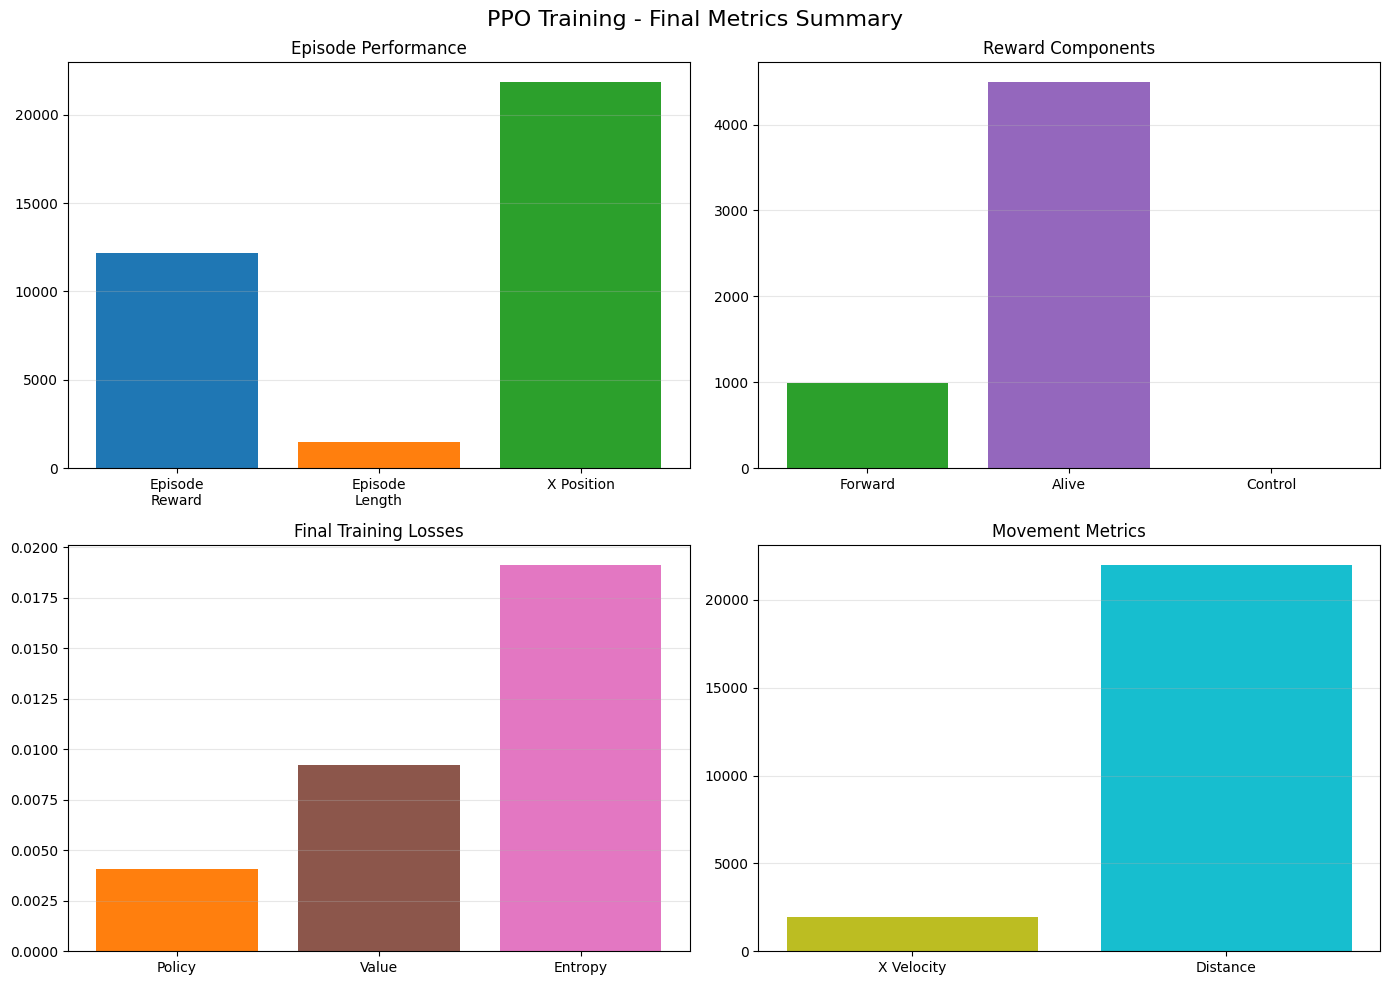

In [7]:
# Plot Training Metrics

import matplotlib.pyplot as plt
import numpy as np

print("📊 Training Metrics Summary")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('PPO Training - Final Metrics Summary', fontsize=16)

# Extract scalar metrics
scalar_metrics = {}
for key, values in metrics.items():
    if hasattr(values, '__array__'):
        values = np.asarray(values)
    if isinstance(values, np.ndarray):
        if values.ndim == 0 or values.size == 1:
            scalar_metrics[key] = float(values)
    else:
        scalar_metrics[key] = values

# Plot 1: Episode Performance
ax1 = axes[0, 0]
performance_metrics = {
    'Episode\nReward': scalar_metrics.get('eval/episode_reward', 0),
    'Episode\nLength': scalar_metrics.get('eval/avg_episode_length', 0),
    'X Position': scalar_metrics.get('eval/episode_x_position', 0),
}
bars1 = ax1.bar(range(len(performance_metrics)), list(performance_metrics.values()), color=['#1f77b4', '#ff7f0e', '#2ca02c'])
ax1.set_xticks(range(len(performance_metrics)))
ax1.set_xticklabels(list(performance_metrics.keys()))
ax1.set_title('Episode Performance')
ax1.grid(True, alpha=0.3, axis='y')

# Plot 2: Reward Components  
ax2 = axes[0, 1]
reward_components = {
    'Forward': scalar_metrics.get('eval/episode_forward_reward', 0),
    'Alive': scalar_metrics.get('eval/episode_reward_alive', 0),
    'Control': scalar_metrics.get('eval/episode_reward_quadctrl', 0),
}
bars2 = ax2.bar(range(len(reward_components)), list(reward_components.values()), color=['#2ca02c', '#9467bd', '#d62728'])
ax2.set_xticks(range(len(reward_components)))
ax2.set_xticklabels(list(reward_components.keys()))
ax2.set_title('Reward Components')
ax2.grid(True, alpha=0.3, axis='y')

# Plot 3: Training Losses
ax3 = axes[1, 0]
losses = {
    'Policy': abs(scalar_metrics.get('training/policy_loss', 0)),
    'Value': scalar_metrics.get('training/v_loss', 0),
    'Entropy': abs(scalar_metrics.get('training/entropy_loss', 0)),
}
ax3.bar(range(len(losses)), list(losses.values()), color=['#ff7f0e', '#8c564b', '#e377c2'])
ax3.set_xticks(range(len(losses)))
ax3.set_xticklabels(list(losses.keys()))
ax3.set_title('Final Training Losses')
ax3.grid(True, alpha=0.3, axis='y')

# Plot 4: Speed Metrics
ax4 = axes[1, 1]
speed_metrics = {
    'X Velocity': scalar_metrics.get('eval/episode_x_velocity', 0),
    'Distance': scalar_metrics.get('eval/episode_distance_from_origin', 0),
}
ax4.bar(range(len(speed_metrics)), list(speed_metrics.values()), color=['#bcbd22', '#17becf'])
ax4.set_xticks(range(len(speed_metrics)))
ax4.set_xticklabels(list(speed_metrics.keys()))
ax4.set_title('Movement Metrics')
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('training_metrics_reward_shaping.png', dpi=150)
print("✓ Saved training metrics to 'training_metrics_reward_shaping.png'")
plt.show()